In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, multivariate_normal

from filterpy.kalman.sigma_points import MerweScaledSigmaPoints

# Closed skewed normal unscented Kalman filters

Reference:

- **Javad Rezaie & Jo Eidsvik (2016)** A skewed unscented Kalman filter, International Journal of Control, 89:12, 2572-2583, DOI: [10.1080/00207179.2016.1171912](https://www.tandfonline.com/doi/full/10.1080/00207179.2016.1171912)

In [2]:
class ClosedSkewedNormal:
    """
    Closed Skewed Normal
    ====================
    
    Input the bivariate normal parameters (mu and Sigma) OR directly the the parameters of the distribution
    (mu_z, Sigma_z, Gamma_z, nu_z, Delta_z).
    
    
    
    """
    def __init__(self, mu=None, Sigma=None, mu_z=None, Sigma_z=None, Gamma_z=None, nu_z=None, Delta_z=None):
        
        bivariate = np.all((mu==None) & (Sigma==None))
        distribution = (mu_z==None) & (Sigma_z==None) & (Gamma_z==None) & (nu_z==None) & (Delta_z==None)
        
        if ~bivariate & distribution:
            self.mu = np.atleast_2d(mu)
            self.Sigma = np.atleast_2d(Sigma)
            
            self._bivariate2z()
            
        elif bivariate & ~distribution:
            self.mu_z = np.atleast_2d(mu_z)
            self.Sigma_z = np.atleast_2d(Sigma_z)
            self.Gamma_z = np.atleast_2d(Gamma_z)
            self.nu_z = np.atleast_2d(nu_z)
            self.Delta_z = np.atleast_2d(Delta_z)
            
            self._z2bivariate()
        else:
            print("No value were correctly inputed.")
            
    def _bivariate2z(self):
        mu = self.mu
        Sigma = self.Sigma
        
        mu_x = mu[0]
        mu_y = mu[1]
        Sigma_x = Sigma[0, 0]
        Sigma_y = Sigma[1, 1]
        Gamma_xy = Sigma[0, 1]
        Gamma_yx = Sigma[1, 0]
        
        self.mu_z = np.atleast_2d(mu_x)
        self.Sigma_z = np.atleast_2d(Sigma_x)
        self.Gamma_z = np.atleast_2d(Gamma_yx/Sigma_x)
        self.nu_z = np.atleast_2d(-mu_y)
        self.Delta_z = np.atleast_2d(Sigma_y - Gamma_yx*Sigma_x**(-1)*Gamma_xy)
    
    def _z2bivariate(self):
        mu_z = float(self.mu_z)
        Sigma_z = float(self.Sigma_z)
        Gamma_z = float(self.Gamma_z)
        nu_z = float(self.nu_z)
        Delta_z = float(self.Delta_z)
    
        self.mu = np.array([
            [ mu_z],
            [-nu_z]
        ])
        self.Sigma = np.array([
            [Sigma_z        , Sigma_z*Gamma_z                  ],
            [Gamma_z*Sigma_z, Delta_z + Gamma_z*Sigma_z*Gamma_z]
        ])
    
    def pdf_bivariate(self, pos):
        """
        Get PDF of bivariate normal
        ===========================
        
        Get the underlying bi-variate normal of the CSN distribution.
        Similar to scipy.multivariate_normal.pdf.
        
        Parameters:
        -----------
        pos : array
        
        Return
        pdf : array
        
        """
        
        nu = self.mu
        Sigma = self.Sigma

        rv = multivariate_normal(nu.flatten(), Sigma)
        
        return rv.pdf(pos)
    
    def pdf_z(self, z):
        """
        Get PDF in z space
        ==================
        
        Parameters:
        -----------
        z : array
        
        Return
        pdf : array
        
        """
        
        mu_z = self.mu_z
        Sigma_z = self.Sigma_z
        Gamma_z = self.Gamma_z
        nu_z = self.nu_z
        Delta_z = self.Delta_z
        
        term1 = norm.cdf(0, nu_z, np.sqrt(Delta_z + Gamma_z*Sigma_z*Gamma_z.T))
        term2 = norm.cdf(Gamma_z*(z - mu_z), nu_z, np.sqrt(Delta_z))
        term3 = norm.pdf(z, mu_z, np.sqrt(Sigma_z))
        
        return (term1**(-1)*term2*term3).flatten()
    
    def get_bivariate_parameters(self):
        # get mean and covatiance of underlying bi-variate normal
        return self.mu, self.Sigma
    
    def get_distribution_parameters(self):
        # get paramters of CSN distribution
        return self.mu_z, self.Sigma_z, self.Gamma_z, self.nu_z, self.Delta_z
    
    def __str__(self):
        text = 'Closed Skewed Normal\n====================\n'
        text += 'Bivariate parameters:\n'
        text += f'  mu:\n{self.mu}\n'
        text += f'  Sigma:\n{self.Sigma}\n'
        text += 'Distribution parameters:\n'
        text += f'  mu_z: {self.mu_z}\n'
        text += f'  Sigma_z : {self.Sigma_z}\n'
        text += f'  Gamma_z : {self.Gamma_z}\n'
        text += f'  nu_z : {self.nu_z}\n'
        text += f'  Delta_z : {self.Delta_z}\n'
        return text

In [3]:
# testing CSN class
test_CSN1 = ClosedSkewedNormal(
    mu_z = np.array([[ 3.0]]),
    nu_z = np.array([[ 4.0]]),
    Sigma_z = np.array([[ 2.0]]),
    Gamma_z = np.array([[-5.0]]),
    Delta_z = np.array([[ 3.0]])
)

mu, Sigma = test_CSN1.get_bivariate_parameters()
print(test_CSN1)

test_CSN2 = ClosedSkewedNormal(
    mu = mu,
    Sigma = Sigma
)
mu_z, Sigma_z, Gamma_z, nu_z, Delta_z = test_CSN2.get_distribution_parameters()
print(test_CSN2)

Closed Skewed Normal
Bivariate parameters:
  mu:
[[ 3.]
 [-4.]]
  Sigma:
[[  2. -10.]
 [-10.  53.]]
Distribution parameters:
  mu_z: [[3.]]
  Sigma_z : [[2.]]
  Gamma_z : [[-5.]]
  nu_z : [[4.]]
  Delta_z : [[3.]]

Closed Skewed Normal
Bivariate parameters:
  mu:
[[ 3.]
 [-4.]]
  Sigma:
[[  2. -10.]
 [-10.  53.]]
Distribution parameters:
  mu_z: [[3.]]
  Sigma_z : [[2.]]
  Gamma_z : [[-5.]]
  nu_z : [[4.]]
  Delta_z : [[3.]]



In [4]:
mu_x_ref, nu_x_ref, Sigma_x_ref, Gamma_x_ref, Delta_x_ref = np.array([[0.0]]), np.array([[0.0]]), np.array([[1.0]]), np.array([[3.0]]), np.array([[1.0]])

all_parameters = [
    (0, '-.', '$\u03BC_x=-2$'  , np.array([[-2.0]]), nu_x_ref          , Sigma_x_ref       , Gamma_x_ref       , Delta_x_ref       ),
    (0, '-' , '$\u03BC_x= 0$'  , np.array([[ 0.0]]), nu_x_ref          , Sigma_x_ref       , Gamma_x_ref       , Delta_x_ref       ),
    (0, '--', '$\u03BC_x= 2$'  , np.array([[ 2.0]]), nu_x_ref          , Sigma_x_ref       , Gamma_x_ref       , Delta_x_ref       ),
    (1, '-.', '$\u03BD_x=-2$'  , mu_x_ref          , np.array([[-2.0]]), Sigma_x_ref       , Gamma_x_ref       , Delta_x_ref       ),
    (1, '-' , '$\u03BD_x= 0$'  , mu_x_ref          , np.array([[ 0.0]]), Sigma_x_ref       , Gamma_x_ref       , Delta_x_ref       ),
    (1, '--', '$\u03BD_x= 2$'  , mu_x_ref          , np.array([[ 2.0]]), Sigma_x_ref       , Gamma_x_ref       , Delta_x_ref       ),
    (2, '-.', '$\u03A3_x= 0.5$', mu_x_ref          , nu_x_ref          , np.array([[ 0.5]]), Gamma_x_ref       , Delta_x_ref       ),
    (2, '-' , '$\u03A3_x= 1$'  , mu_x_ref          , nu_x_ref          , np.array([[ 1.0]]), Gamma_x_ref       , Delta_x_ref       ),
    (2, '--', '$\u03A3_x= 2$'  , mu_x_ref          , nu_x_ref          , np.array([[ 2.0]]), Gamma_x_ref       , Delta_x_ref       ),
    (3, '-.', '$\u0393_x=-3$'  , mu_x_ref          , nu_x_ref          , Sigma_x_ref       , np.array([[-3.0]]), Delta_x_ref       ),
    (3, '-' , '$\u0393_x= 3$'  , mu_x_ref          , nu_x_ref          , Sigma_x_ref       , np.array([[ 3.0]]), Delta_x_ref       ),
    (3, '--', '$\u0393_x= 0$'  , mu_x_ref          , nu_x_ref          , Sigma_x_ref       , np.array([[ 0.0]]), Delta_x_ref       ),
    (4, '-.', '$\u0394_x= 0.5$', mu_x_ref          , nu_x_ref          , Sigma_x_ref       , Gamma_x_ref       , np.array([[ 0.5]])),
    (4, '-' , '$\u0394_x= 1$'  , mu_x_ref          , nu_x_ref          , Sigma_x_ref       , Gamma_x_ref       , np.array([[ 1.0]])),
    (4, '--', '$\u0394_x= 2$'  , mu_x_ref          , nu_x_ref          , Sigma_x_ref       , Gamma_x_ref       , np.array([[ 2.0]])),
    (5, '-' , '$\u03BC_x= 3$, $\u03A3_x= 2$, $\u0393_x=-5$, $\u03BD_x= 4$, $\u0394_x= 3$', np.array([[ 3.0]]), np.array([[ 4.0]]), np.array([[ 2.0]]), np.array([[-5.0]]), np.array([[ 3.0]]))
]

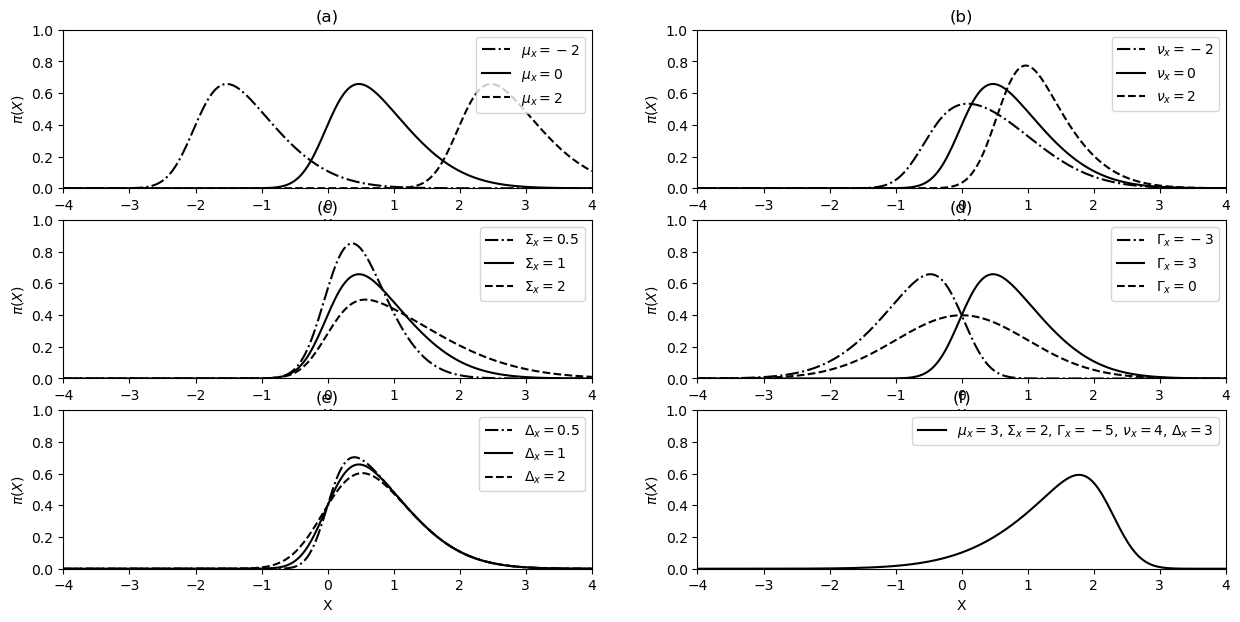

In [19]:
# plotting
x = np.linspace(-4, 4, num=250)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,7))
axes = axes.flatten()
for ax_i, ls, label, mu_x, nu_x, Sigma_x, Gamma_x, Delta_x in all_parameters:
    csn = ClosedSkewedNormal(
        mu_z = mu_x, 
        nu_z = nu_x, 
        Sigma_z = Sigma_x, 
        Gamma_z = Gamma_x, 
        Delta_z = Delta_x)
    csn_dist = csn.pdf_z(x)
    axes[ax_i].plot(x, csn_dist, ls=ls, color='k', label=label)
    axes[ax_i].set_xlim((-4, 4))
    axes[ax_i].set_ylim((0, 1))

for ax, title in zip(axes, ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]):
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("$\pi(X)$")

Effects of changing the CSN distributions parameters (the reference parameters are $\mu_X = 0$, $v_X=0$, $\Sigma_X = 1$, $\Gamma_X = 3$, $\Delta_X = 1$):
sensitivity to (a) $\mu_X$; (b) $v_X$; (c) $\Sigma_X$; (d) $\Gamma_X$; (e) $\Delta_X$; (f) all parameters change together.

Reference: [Javad Rezaie & Jo Eidsvik (2016)](https://www.tandfonline.com/doi/full/10.1080/00207179.2016.1171912), Figure 2.

In [21]:
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman.sigma_points import MerweScaledSigmaPoints
from filterpy.kalman.unscented_transform import unscented_transform

In [22]:
g = lambda x : -np.sin(2*x/5)

# prior distribution
csn_prior_dist = ClosedSkewedNormal(mu_z=-1.0, Sigma_z=2.5, Gamma_z=2.0, nu_z=-.5, Delta_z=1)
mu_prior, P_prior = csn_prior_dist.get_bivariate_parameters()
SigmaPoints = MerweScaledSigmaPoints(2, alpha=0.8, beta=2., kappa= 0.0)
sigmas_prior = SigmaPoints.sigma_points(mu_prior.flatten(), P_prior)
Wm = SigmaPoints.Wm
Wc = SigmaPoints.Wc

# propagation
sigmas_pos = sigmas_prior.copy()
sigmas_pos[:,0] = g(sigmas_pos[:,0])
mu_pos, P_pos = unscented_transform(sigmas_pos, Wm, Wc, noise_cov=None,
                        mean_fn=None, residual_fn=None)

# forward propagated distribution
csn_pos_dist = ClosedSkewedNormal(
    mu=np.atleast_2d(mu_pos).T, 
    Sigma=P_pos)

C:\Users\User\AppData\Local\Temp\ipykernel_40828\2533327351.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  axes[0,1].contour(X, Y, csn_prior_dist.pdf_bivariate(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of X")
C:\Users\User\AppData\Local\Temp\ipykernel_40828\2533327351.py:35: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1,1].contour(X, Y, csn_pos_dist.pdf_bivariate(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of Y")


Prior
[[-1. ]
 [ 0.5]] [[ 2.5  5. ]
 [ 5.  11. ]]
Prediction
[0.31480151 0.5       ] [[ 0.299938   -1.68890305]
 [-1.68890305 11.        ]]


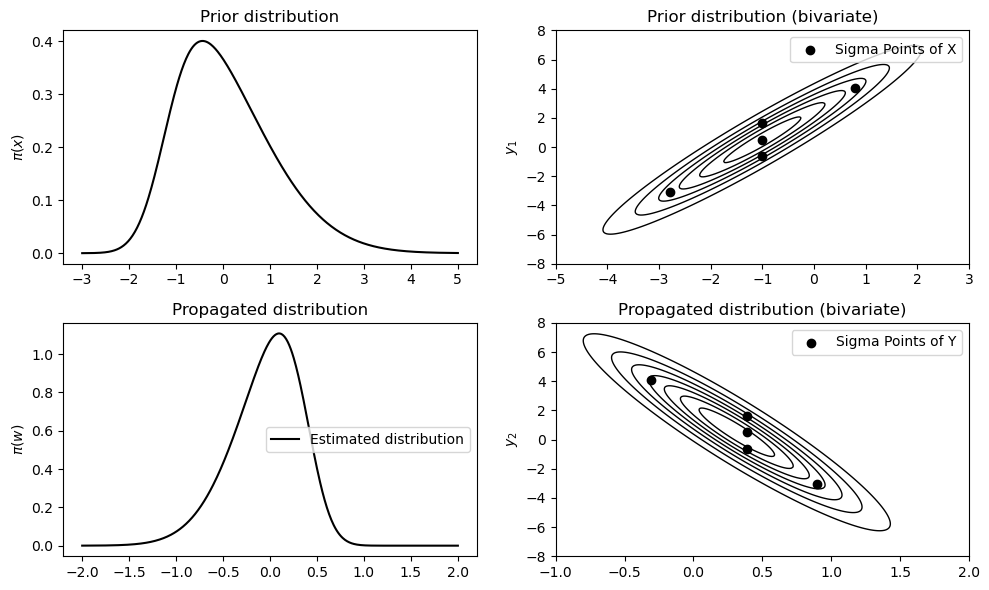

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

x_axis = np.linspace(-3, 5, num=500)
x_biv = np.linspace(-5, 3, num = 250)
y_biv = np.linspace(-8, 8, num = 250)
X, Y = np.meshgrid(x_biv, y_biv)
pos = np.dstack((X, Y))

axes[0,0].set_title("Prior distribution")
axes[0,0].plot(x_axis, csn_prior_dist.pdf_z(x_axis), color= 'k')
axes[0,0].set_ylabel("$X$")
axes[0,0].set_ylabel("$\pi(x)$")


axes[0,1].set_title("Prior distribution (bivariate)")
axes[0,1].contour(X, Y, csn_prior_dist.pdf_bivariate(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of X")
axes[0,1].scatter(sigmas_prior[:,0], sigmas_prior[:,1], color='k', label="Sigma Points of X")
axes[0,1].set_ylabel("$X$")
axes[0,1].set_ylabel("$y_1$")
axes[0,1].legend()

x_axis = np.linspace(-2, 2, num = 500)
x_biv = np.linspace(-1, 2, num = 250)
y_biv = np.linspace(-8, 8, num = 250)
X, Y = np.meshgrid(x_biv, y_biv)
pos = np.dstack((X, Y))

axes[1,0].set_title("Propagated distribution")
axes[1,0].plot(x_axis, csn_pos_dist.pdf_z(x_axis), color= 'k', label="Estimated distribution")
axes[1,0].set_ylabel("$W$")
axes[1,0].set_ylabel("$\pi(w)$")
axes[1,0].legend()

axes[1,1].set_title("Propagated distribution (bivariate)")
axes[1,1].contour(X, Y, csn_pos_dist.pdf_bivariate(pos), linewidths=1, linestyles='solid', colors='k', label="Distribution of Y")
axes[1,1].scatter(sigmas_pos[:,0], sigmas_pos[:,1], color='k', label="Sigma Points of Y")
axes[1,1].set_ylabel("$X$")
axes[1,1].set_ylabel("$y_2$")
axes[1,1].legend()

fig.tight_layout()

print("Prior")
print(mu_prior, P_prior)
print("Prediction")
print(mu_pos, P_pos)

The CSN distribution estimation by SUT on extended space for the function $w = - \sin (2x/5)$

Reference: [Javad Rezaie & Jo Eidsvik (2016)](https://www.tandfonline.com/doi/full/10.1080/00207179.2016.1171912), Figure 3.

# CSNUKF validation with UKF

Basic testing of of CSN and UKF.

In [9]:
from filterpy.kalman.UKF import UnscentedKalmanFilter
from filterpy.kalman.sigma_points import MerweScaledSigmaPoints

In [10]:
# general parameters
x, P = 5, 0.8
fx = lambda x, dt : 1.2*x*dt
hx = lambda x : x

# observations
time   = [1    , 2    , 3    , 4    , 5   , 6    , 7    , 8   , 9    , 10  ]
z_list = [None , None , None , None , 11. , None , None , 26. , None,  30. ]
R_list = [None , None , None , None , 2.0 , None , None , 2.0 , None,  2.0 ]

In [11]:
# Unscented Kalman filter
ukf = UnscentedKalmanFilter(
    dim_x=1, dim_z=1, dt=1, fx=fx, hx=hx, points= MerweScaledSigmaPoints(1, alpha=0.001, beta=2, kappa=0))
ukf.x, ukf.P = x, P
ukf_results = [[0, x, P]]
for t, z, R in zip(time, z_list, R_list):
    ukf.predict()
    ukf_results.append([t, float(ukf.x), float(ukf.P)])
    if z is not None:
        ukf.update(z, R)
        ukf_results.append([t, float(ukf.x), float(ukf.P)])
ukf_results = np.array(ukf_results)

In [12]:
# adaptations for bivariate
fx = lambda x, dt : np.array([1.2*x[0]*dt, x[1]])
hx = lambda x : np.array([x[0]])

csn = ClosedSkewedNormal(mu_z=5, Sigma_z=0.8, Gamma_z=0.0, nu_z=0.0, Delta_z=2)

# Closed Skewed Normal Unscented Kalman Filter
csnukf = UnscentedKalmanFilter(
    dim_x=2, dim_z=1, dt=1, fx=fx, hx=hx, points= MerweScaledSigmaPoints(2, alpha=0.001, beta=2, kappa=0))
csnukf.x, csnukf.P = csn.mu.flatten(), csn.Sigma
csnukf_results = [[0, csnukf.x[0], csnukf.P[0,0]]]
for t, z, R in zip(time, z_list, R_list):
    csnukf.predict()
    csnukf_results.append([t, csnukf.x[0], csnukf.P[0,0]])
    if z is not None:
        csnukf.update(z, R)
        csnukf_results.append([t, csnukf.x[0], csnukf.P[0,0]])
csnukf_results = np.array(csnukf_results)

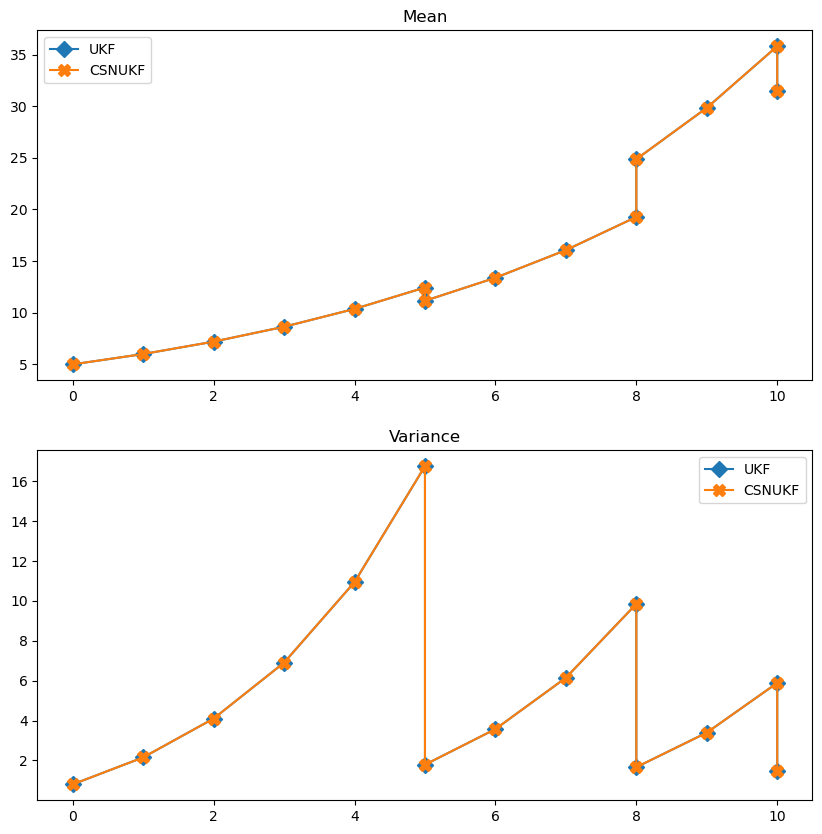

In [13]:
# plotting
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

axes[0].set_title("Mean")
axes[0].plot(ukf_results[:,0], ukf_results[:,1], label='UKF', marker="D", ms=8)
axes[0].plot(csnukf_results[:,0], csnukf_results[:,1], label='CSNUKF', marker="X", ms=8)
axes[0].legend()
axes[1].set_title('Variance')
axes[1].plot(ukf_results[:,0], ukf_results[:,2], label='UKF', marker="D", ms=8)
axes[1].plot(csnukf_results[:,0], csnukf_results[:,2], label='CSNUKF', marker="X", ms=8)
axes[1].legend()

# Numerical experiments
Numerical examples for the paper.

In [ ]:
# TODO

## Re-entering body to the atmosphere

In [ ]:
# TODO

## Simple pendulum

In [ ]:
# TODO